In [ ]:
%cd Heartbeat-Sound-Classifier

/content/Heartbeat-Sound-Classifier


In [ ]:
!pip install nbimporter
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
""" Basic Utils """
import warnings
from IPython.display import HTML, IFrame

""" Data Analysis and Visualization """
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import label_binarize
import EDA; import MFCC
from scipy import interp

""" Audio Analysis """
import librosa.display
import scipy.io.wavfile
from scipy.fftpack import dct

""" Model Evaluation """
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import scikitplot as skplt

""" Keras Functional API """
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


INPUT_PATH = "/content/drive/MyDrive/dataset/"
AUDIO_DURATION = 2
SAMPLE_RATE = 22050

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_a = pd.read_csv(INPUT_PATH + "set_a.csv").drop('sublabel', axis = 1).dropna()
df_b = pd.read_csv(INPUT_PATH + "set_b.csv").drop('sublabel', axis = 1).dropna()


In [ ]:
df = pd.concat([df_a, df_b], ignore_index=True)

In [ ]:
def load_audio(fname, offset=0, duration=None):
    """loads the audio"""
    try:
        y, sr = librosa.load(INPUT_PATH + "set_a/" + fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
    except IOError:
        y, sr = librosa.load(INPUT_PATH + "set_b/" + fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
    except NameError:
        print("{0} does not exist".format(fname))
    return(y)

def combine_normal_extrastole(f):
    if f == "normal":
        return("normal/extrastole")
    elif f == "extrastole":
        return("normal/extrastole")
    else:
        return(f)

In [ ]:
warnings.filterwarnings('ignore')
df['fname'] = df['fname'].apply(lambda f:f.split('/')[1])
df['time_series'] = df['fname'].apply(load_audio)   # audio signals
df['duration (seconds)'] = round(df['time_series'].apply(len) / SAMPLE_RATE, 1)
df['label'] = df['label'].apply(combine_normal_extrastole)

In [ ]:
df

,dataset,fname,label,time_series,duration (seconds)
0,a,artifact__201012172012.wav,artifact,"[2.2960085e-05, -0.00012982322, -0.00018070513...",9.0
1,a,artifact__201105040918.wav,artifact,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",9.0
2,a,artifact__201105041959.wav,artifact,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",9.0
3,a,artifact__201105051017.wav,artifact,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",9.0
4,a,artifact__201105060108.wav,artifact,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",9.0
...,...,...,...,...,...
580,b,normal_noisynormal_284_1311168471850_A.wav,normal/extrastole,"[-0.0017416242, -0.0017414236, -0.0013176143, ...",12.1
581,b,normal_noisynormal_284_1311168471850_B.wav,normal/extrastole,"[0.01970284, 0.020814508, 0.020401765, 0.01850...",12.0
582,b,normal_noisynormal_285_1311169246969_C.wav,normal/extrastole,"[0.009974569, 0.011469088, 0.0126834605, 0.013...",4.8
583,b,normal_noisynormal_296_1311682952647_C.wav,normal/extrastole,"[8.301545e-05, -0.0011210624, -0.0027663005, -...",13.1


In [ ]:
cond_counts = df['label'].value_counts()
min_duration = df.groupby('label')['duration (seconds)'].min()
max_duration = df.groupby('label')['duration (seconds)'].max()
mean_duration = df.groupby('label')['duration (seconds)'].max()
total_duration = df.groupby('label')['duration (seconds)'].sum()

audio_duration_dict = {'min duration (sec)' : min_duration, 'max duration (sec)': max_duration, 'mean duration (sec)':mean_duration, 
                       'total duration (sec)':total_duration, 'number of samples (#)': cond_counts}
audio_duration_summary = pd.DataFrame(audio_duration_dict)
display(HTML('<h1 style="text-indent: 300px;">Auditory Duration Summary</h1>'))
pd.DataFrame(audio_duration_dict)

,min duration (sec),max duration (sec),mean duration (sec),total duration (sec),number of samples (#)
artifact,9.0,9.0,9.0,360.0,40
extrahls,0.9,9.0,9.0,130.5,19
murmur,0.9,24.2,24.2,1001.7,129
normal/extrastole,0.8,27.9,27.9,2486.5,397


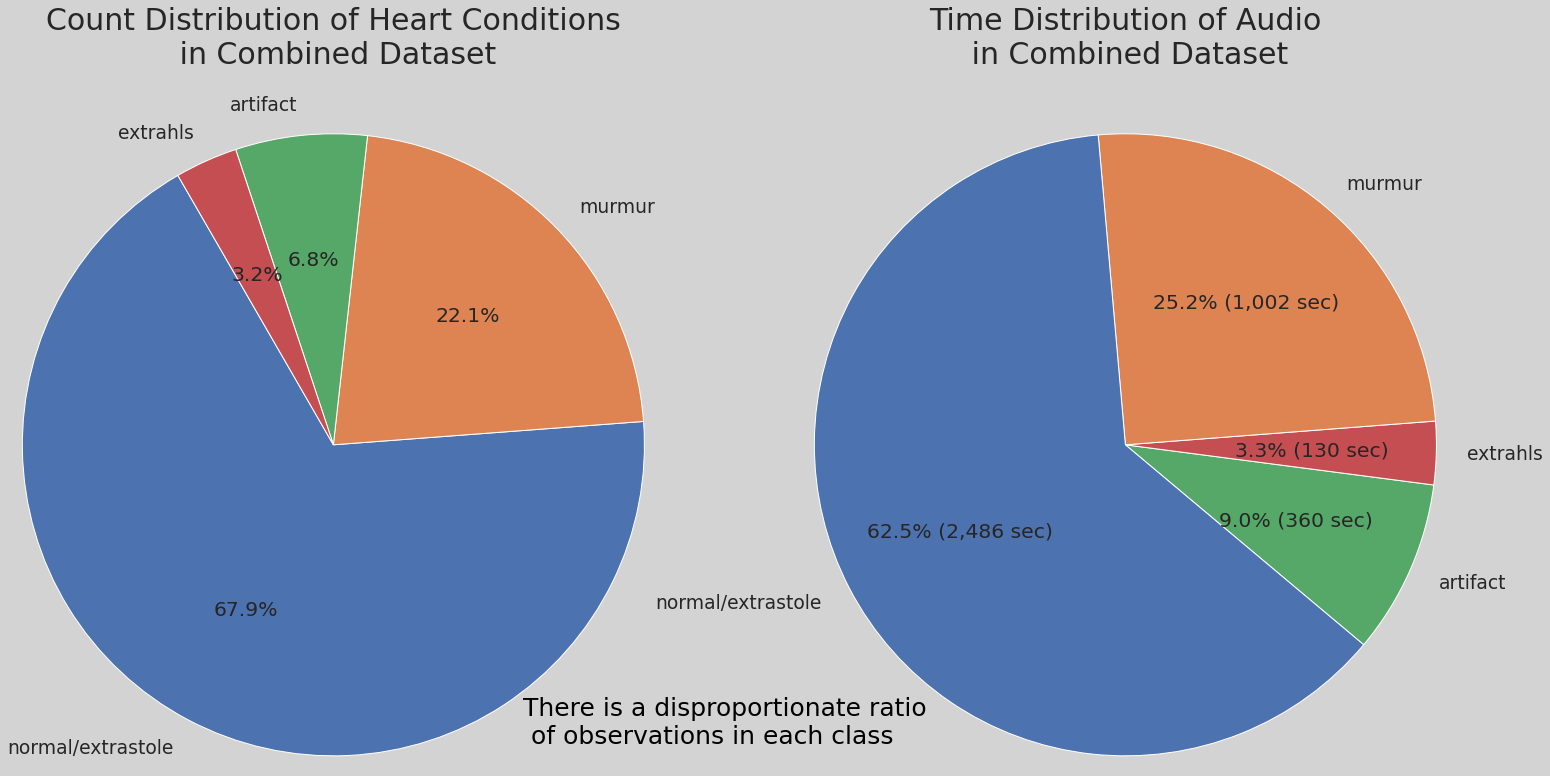

In [ ]:
class_labels = list(cond_counts.index)
time_labels = list(total_duration.index)
label_counts = cond_counts.tolist()
duration_count = total_duration.tolist()

EDA.plot_two_distr(class_labels, label_counts, time_labels, duration_count)

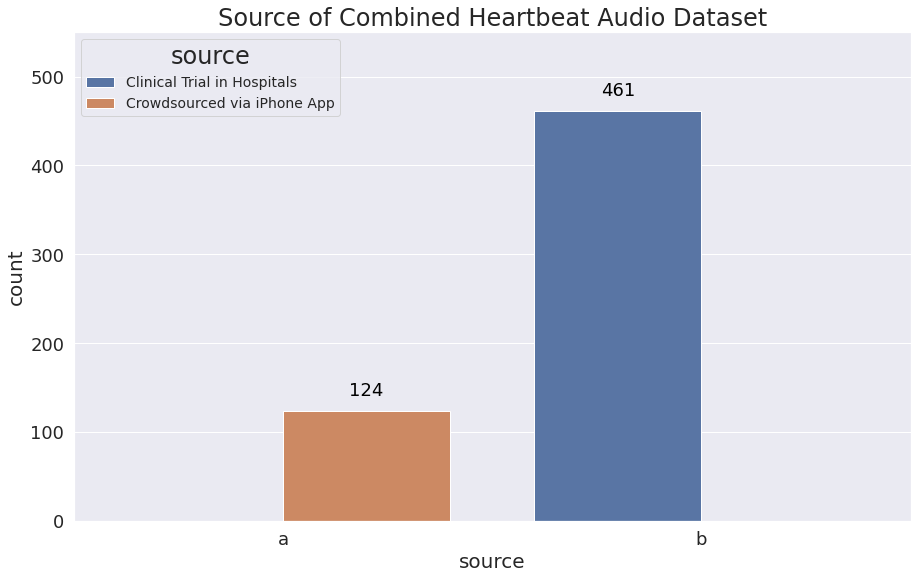

In [ ]:
source_count = df['dataset'].value_counts()
l = source_count.to_frame()
l.reset_index(inplace=True)
l.columns = ['source', 'count']

EDA.plot_source_distr(l)

In [ ]:
""" Functions for Feature Extraction """

def new_extract_mfccs(y):
    return(np.mean(librosa.feature.mfcc(y, sr=SAMPLE_RATE, n_mfcc=13).T,axis=0))

def new_extract_zcr(y):
    return(np.mean(librosa.feature.zero_crossing_rate(y)))

def new_extract_bandwidth(y):
    return(np.mean(librosa.feature.spectral_bandwidth(y, SAMPLE_RATE)))

In [ ]:
training_df = df.sample(frac = 0.99, random_state=42)
testing_df = df[~df['fname'].isin(training_df['fname'])]

In [ ]:
testing_df

,dataset,fname,label,time_series,duration (seconds)
20,a,artifact__201106070949.wav,artifact,"[-0.058806445, -0.05314862, 0.15015475, 0.3976...",9.0
71,a,murmur__201108222223.wav,murmur,"[0.01639377, 0.026940092, 0.02657546, 0.029489...",7.9
102,a,normal__201103140132.wav,normal/extrastole,"[0.00015239976, 4.521341e-05, -0.00010498433, ...",9.0
106,a,normal__201103170121.wav,normal/extrastole,"[-0.0020855921, -0.0029325464, -0.0024543959, ...",8.0
270,b,normal__137_1306764999211_D.wav,normal/extrastole,"[-0.023912814, -0.025504176, -0.025981056, -0....",5.9
435,b,normal__300_1311772096120_C1.wav,normal/extrastole,"[0.002532933, 0.002023998, 0.0013675537, 0.000...",5.4


In [ ]:
print("=== Training Dataset ===")
print(training_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}\n".format(len(training_df)))
print("=== Test Dataset ===")
print(testing_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}".format(len(testing_df)))

=== Training Dataset ===
dataset  label            
a        artifact              39
         murmur                33
         normal/extrastole     29
         extrahls              19
b        normal/extrastole    364
         murmur                95
Name: label, dtype: int64

number of rows = 579

=== Test Dataset ===
dataset  label            
a        normal/extrastole    2
         artifact             1
         murmur               1
b        normal/extrastole    2
Name: label, dtype: int64

number of rows = 6


In [ ]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

"""Splits the audio into 2 second chunks"""
def split_audio(fname):
    new_training_df = pd.DataFrame()
    duration =  training_df[training_df['fname'] == fname]['duration (seconds)'].values[0]
    i = 0; count = 1
    my_list = []
    
    y = load_audio(fname,0,2)            
    if duration < 2:
        y = repeat_to_length(y, SAMPLE_RATE*2)
        
    while True:
        if i > 0:            
            y = load_audio(fname, offset=i, duration=AUDIO_DURATION)
        
        data = {
         'fname' : fname + "_" + str(count),
         'label' : df[df['fname'] == fname]['label'].values[0],
         'time_series' : [y],
         'mfccs' : [ new_extract_mfccs(y) ],
         'zcr' : [ new_extract_zcr(y) ],
         'bandwidth' : [ new_extract_bandwidth(y) ],
         'duration (seconds)' : round(len(y) / SAMPLE_RATE, 1)
        }
        
        my_list.append(pd.DataFrame(data))
        
        i += 2; count += 1
        if (i + 2) > duration: break
    my_list = pd.concat(my_list)
    new_training_df = new_training_df.append(pd.DataFrame(my_list))
    
    return(new_training_df)

In [ ]:
""" Generate More Training Data """
new_training_df = training_df['fname'].apply(split_audio)

keys = [s for s in new_training_df]
new_training_df = pd.concat(keys)

In [ ]:
""" List the unique values in the duration column """
new_training_df['duration (seconds)'].unique()


array([2.])

In [ ]:
""" Separate majority and minority classes """
train_df_majority = new_training_df[new_training_df.label=="normal/extrastole"]
train_df_minority1 = new_training_df[new_training_df.label=="murmur"]
train_df_minority2 = new_training_df[new_training_df.label=="extrahls"]
train_df_minority3 = new_training_df[new_training_df.label=="artifact"]

In [ ]:
majority_num = train_df_majority.shape[0]

""" Upsample the minority classes """
df_minority1_upsampled = resample(train_df_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_num,    # to match majority class
                                 random_state=42) # reproducible results

df_minority2_upsampled = resample(train_df_minority2, 
                                 replace=True,     
                                 n_samples=majority_num,    
                                 random_state=42) 

df_minority3_upsampled = resample(train_df_minority3, 
                                 replace=True,     
                                 n_samples=majority_num,    
                                 random_state=42)

In [ ]:
""" Combine majority class with the upsampled minority classes """
df_upsampled = pd.concat([train_df_majority, 
                          df_minority1_upsampled, 
                          df_minority2_upsampled,
                          df_minority3_upsampled], 
                         ignore_index=False)

In [ ]:
""" Display new class Distribution """
print("New Class Distribution")
df_upsampled.label.value_counts()

New Class Distribution


normal/extrastole    1085
murmur               1085
extrahls             1085
artifact             1085
Name: label, dtype: int64

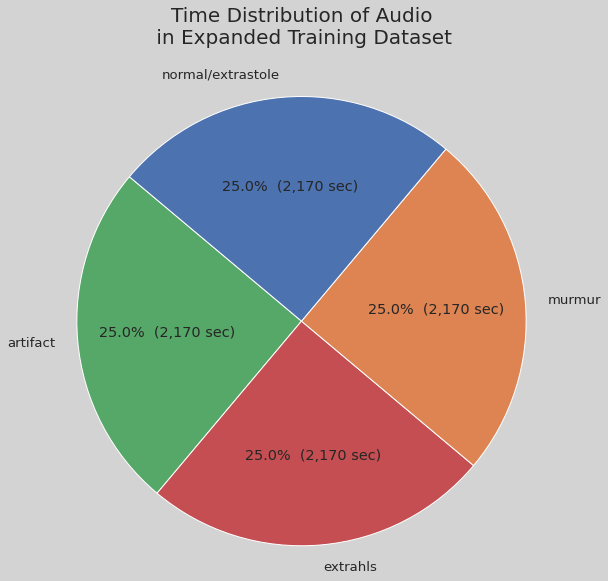

In [ ]:
total_duration = df_upsampled.groupby('label')['duration (seconds)'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

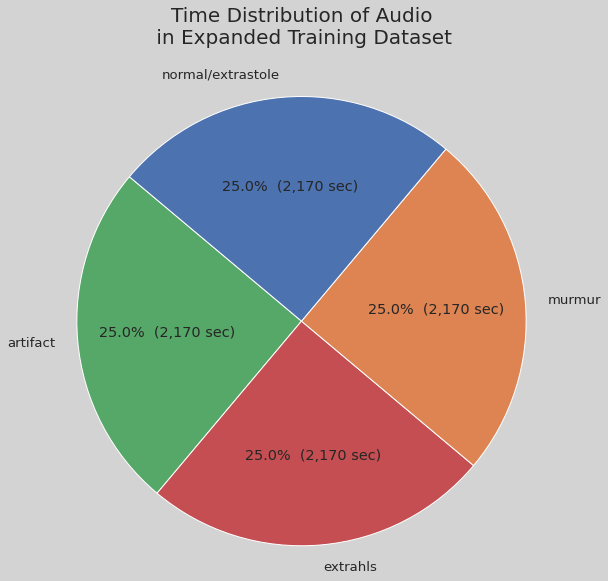

In [ ]:
total_duration = df_upsampled.groupby('label')['duration (seconds)'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

In [ ]:
mfccs = np.vstack(df_upsampled['mfccs'])
zcr = np.vstack(df_upsampled['zcr'])
bandwidth = np.vstack(df_upsampled['bandwidth'])

# test_mfccs = np.vstack(testing_df['mfccs'])
# test_zcr = np.vstack(testing_df['zcr'])
# test_bandwidth = np.vstack(testing_df['bandwidth'])

""" Normalize the training data """
mfccs = mfccs / np.std(mfccs, axis=0)
zcr = zcr / np.std(zcr, axis=0)
bandwidth = bandwidth / np.std(bandwidth, axis=0)

# """ Normalize the testing data """
# test_mfccs = test_mfccs / np.std(test_mfccs, axis=0)
# test_zcr = test_zcr / np.std(test_zcr, axis=0)
# test_bandwidth = test_bandwidth / np.std(test_bandwidth, axis=0)

In [ ]:
trainLabels_encoded = pd.get_dummies(df_upsampled['label'])


In [ ]:
""" Define Callback Function """
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

checkpoint = ModelCheckpoint("weights.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, annealer]


In [ ]:
num_rows = 13
num_columns = 1
num_channels = 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers
inputs = layers.Input(shape=(13, 1, 3))
x = inputs
model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

# Freeze the pretrained weights
#     model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(4, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
import cv2
imgs = []
xx=np.expand_dims(np.expand_dims(mfccs,axis=2),axis=3)
for fn in xx:
    im = cv2.cvtColor(fn, cv2.COLOR_GRAY2RGB)
    imgs.append(im)
xx=np.array(imgs)


In [ ]:
tf.config.run_functions_eagerly(True)


In [ ]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(xx, trainLabels_encoded, test_size=0.2, random_state = 42)

In [ ]:
len(xx)

4340

In [ ]:
history = model.fit(x = xx,
                    y = trainLabels_encoded,
                    validation_split=0.2,
                    epochs = 10,
                   callbacks=callbacks_list,
                   verbose=1)

In [ ]:
testylabels=[]
x=0
for i in y_test.to_numpy():
    if i[0] == 1:
        testylabels.append(0)
    elif i[1] == 1:
        testylabels.append(1)
    elif i[2] == 1:
        testylabels.append(2)
    elif i[3] == 1:
        testylabels.append(3)
#     print(i[0],i[1],i[2],i[3])
    x+=1
print(len(testylabels))


868


In [ ]:
y_prob = model.predict(x_test)
y_classes = y_prob.argmax(axis=-1)

labelsDict = {'artifact': 0, 'extrahls':1, 'murmur':2, 'normal/extrastole':3}
y_actu = testylabels
y_pred = y_classes.tolist()

# binarize/hotencode y_actu
y_binary = label_binarize(np.array(y_actu), classes=[0,1,2,3])
n_classes = y_binary.shape[1]    # 4 classes

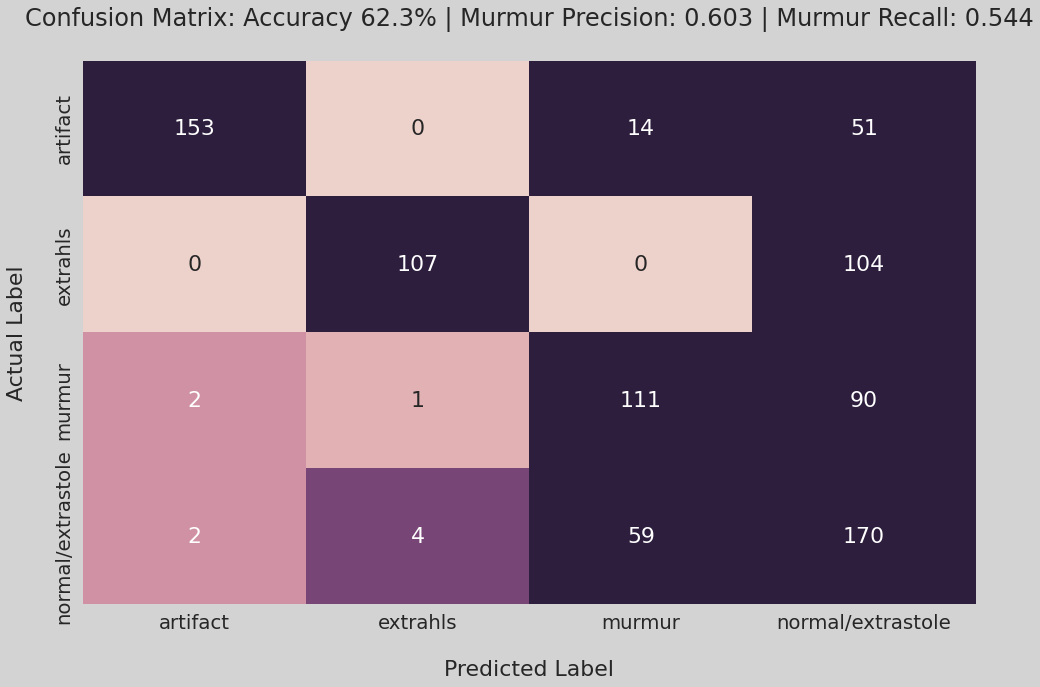

In [ ]:
from IPython.display import display, HTML

plt.figure(figsize=(16,10),facecolor='lightgrey')

array = confusion_matrix(y_actu, y_pred).tolist()
categories = ["artifact","extrahls","murmur","normal/extrastole"]
df_cm = pd.DataFrame(array, index = categories, columns = categories)

"""Compute Precision, Recall, F-score """
precision = pd.Series(np.diag(df_cm) / np.sum(df_cm, axis = 0), name='precision')
recall = pd.Series(np.diag(df_cm) / np.sum(df_cm, axis = 1), name='recall')
fscore = pd.Series(2 * precision * recall / (precision + recall), name='F-score')
murmur_precison = round(precision['murmur'],3)
murmur_recall = round(recall['murmur'],3)

sns.set(font_scale=1.8) # label size
sns.heatmap(df_cm, annot=True, square = False, annot_kws={"size": 22}, 
            fmt="d", cmap = sns.cubehelix_palette(8), vmin = 0, vmax = 6, cbar=False)


plt.ylabel('Actual Label\n', size = 22);
plt.xlabel('\nPredicted Label', size = 22); 
cm_title = "Confusion Matrix: Accuracy {0}% | Murmur Precision: {1} | Murmur Recall: {2}\n".format(
    round(accuracy_score(y_actu, y_pred)*100, 1), murmur_precison, murmur_recall)
plt.title(cm_title, size = 24);

In [ ]:
pd.concat([precision, recall, fscore], axis=1)


,precision,recall,F-score
artifact,0.974522,0.701835,0.816000
extrahls,0.955357,0.507109,0.662539
murmur,0.603261,0.544118,0.572165
normal/extrastole,0.409639,0.723404,0.523077


In [ ]:
"""Compute ROC curve and ROC area for each class"""
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

"""Compute micro-average ROC curve and ROC area"""
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
"""Compute macro-average ROC curve and ROC area"""

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

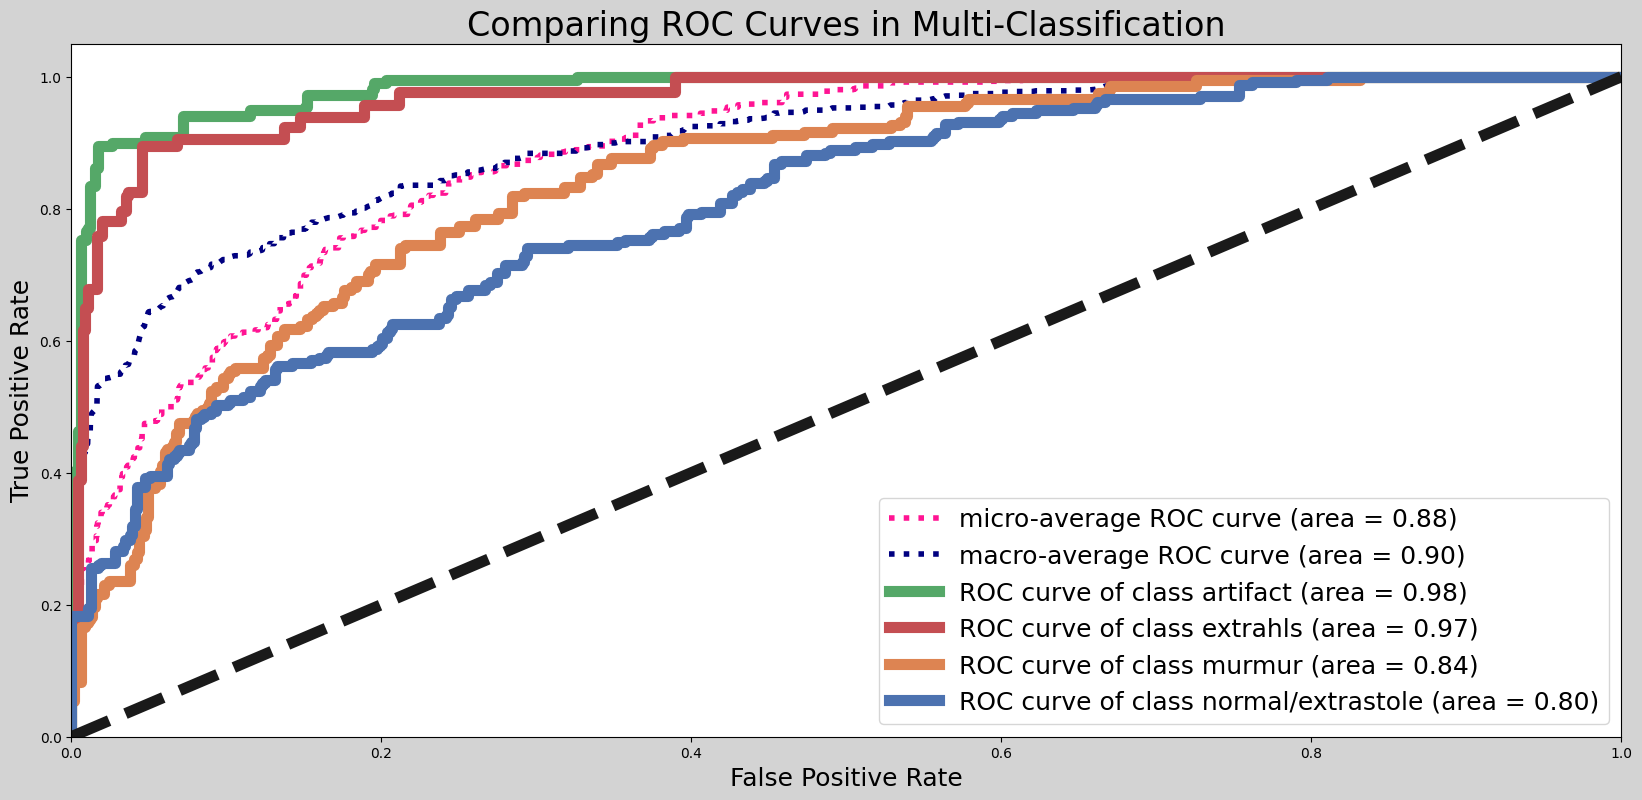

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(20,9), facecolor='lightgrey')
lw = 8            # line width
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['#55A868', '#C44E52', '#DD8452', '#4C72B0']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Comparing ROC Curves in Multi-Classification', fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.show()

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.8 MB/s 
     |████████████████████████████████| 2.3 MB 54.4 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 140 kB 62.1 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 272 kB 70.2 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 
     |████████████████████████████████| 144 kB 61.2 MB/s 
     |████████████████████████████████| 271 kB 66.3 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 68 kB

In [ ]:
import cv2
def predict_disease(filepath):

  def load_audio_test(fname, offset=0, duration=None):
      """loads the audio"""
      try:
          y, sr = librosa.load(fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
      except IOError:
          y, sr = librosa.load(fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
      except NameError:
          print("{0} does not exist".format(fname))
      return(y)


  def new_extract_mfccs_test(y):
      return(np.mean(librosa.feature.mfcc(y, sr=SAMPLE_RATE, n_mfcc=13).T,axis=0))
  
  
  newmfcc=new_extract_mfccs(load_audio_test(filepath) / np.std(new_extract_mfccs_test(load_audio_test(filepath)), axis=0))
  imgs = []
  xx=np.expand_dims(np.expand_dims(newmfcc,axis=1),axis=2)

  im = cv2.cvtColor(xx, cv2.COLOR_GRAY2RGB)
  imgs=[]
  imgs.append(im)
  imgs=np.array(imgs)
  
  labelsDict = {'artifact': 0, 'extrahls':1, 'murmur':2, 'normal/extrastole':3}
  prediction_array=model.predict(imgs)

  j=0
  for i,v in labelsDict.items():
    labelsDict[i]=float(prediction_array[0][j])
    j+=1
  return labelsDict
filepath='/content/drive/MyDrive/dataset/set_a/artifact__201012172012.wav'
labelsDict=predict_disease(filepath)
labelsDict

{'artifact': 0.0, 'extrahls': 0.0, 'murmur': 1.0, 'normal/extrastole': 0.0}

In [ ]:
import tensorflow as tf
import requests
import gradio as gr


gr.Interface(fn=predict_disease, 
             inputs=gr.inputs.Audio(type='filepath'),
             outputs=gr.outputs.Label(num_top_classes=4)).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://36796.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
